In [1]:
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from dateutil import parser
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
train_ds = 'D:/PaperWork/personal/AI/VertexAI/training-data-analyst/courses/machine_learning/deepdive2/feature_engineering/labs/../../../data/traffic-taxi-train.csv'
test_ds = 'D:/PaperWork/personal/AI/VertexAI/training-data-analyst/courses/machine_learning/deepdive2/feature_engineering/labs/../../../data/traffic-taxi-test.csv'
validation_ds = 'D:/PaperWork/personal/AI/VertexAI/training-data-analyst/courses/machine_learning/deepdive2/feature_engineering/labs/../../../data/traffic-taxi-valid.csv'

csv_cols = ['fare_amount',
                'pickup_datetime',
                'pickup_longitude',
                'pickup_latitude',
                'dropoff_longitude',
                'dropoff_latitude',
                'passenger_count',
                'trips_last_5min',
                'key']

num_cols = ['pickup_longitude',
            'pickup_latitude',
            'dropoff_longitude',
            'dropoff_latitude',
            'passenger_count']
string_cols = ['pickup_datetime']
label_col = 'fare_amount'
unwanted_cols = ['key','trips_last_5min']
defaults = [[0.0], [''], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
DAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
DAYS_DICT = {idx: day for idx, day in enumerate(DAYS)}

In [2]:

# print the parent directory of the current file
def read_data(file_path):    
    df = pd.read_csv(file_path, names=csv_cols, header=0, na_values='', dtype={'fare_amount': 'float32',
                                                                           'pickup_datetime': 'string',
                                                                           'pickup_longitude': 'float32',
                                                                           'pickup_latitude': 'float32',
                                                                           'dropoff_longitude': 'float32',
                                                                           'dropoff_latitude': 'float32',
                                                                           'passenger_count': 'float32',
                                                                           'trips_last_5min': 'float32',
                                                                           'key': 'float32'})
    for col in unwanted_cols:
        df.pop(col)
    return df
def convert_pickup_datetime(dt):    
    ts = parser.parse(dt)
    return DAYS_DICT.get(ts.weekday(),'Unknown'), ts.hour

In [3]:
df= read_data(train_ds)


In [4]:
num_bins=5
df= read_data(train_ds)
longs = np.concatenate([df['pickup_longitude'], df['dropoff_longitude']], axis=0).flatten()
lats = np.concatenate([df['pickup_latitude'], df['dropoff_latitude']], axis=0).flatten()
discretizer_long = layers.Discretization(name='discretize_longitude', num_bins=num_bins)
discretizer_lat = layers.Discretization(name='discretize_latitude', num_bins=num_bins)
discretizer_long.adapt(longs)
discretizer_lat.adapt(lats)

# print(df.head())
# print(df.describe())
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
def haversine_distance(coords):
    lat1, lon1, lat2, lon2 = coords
    PI = tf.constant(np.pi, dtype=tf.float32)
    R = tf.constant(6371.0, dtype=tf.float32)  # Earth radius in kilometers
    lat1_rad = lat1 * (PI / 180.0)
    lon1_rad = lon1 * (PI / 180.0)
    lat2_rad = lat2 * (PI / 180.0)
    lon2_rad = lon2 * (PI / 180.0)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = tf.math.sin(dlat / 2) ** 2 + tf.math.cos(lat1_rad) * tf.math.cos(lat2_rad) * tf.math.sin(dlon / 2) ** 2
    c = 2 * tf.asin(tf.sqrt(a))

    distance = R * c
    distance.set_shape([None])
    return distance



def build_model():
    
    inputs = {col: layers.Input(name=col, shape=(), dtype='float32') for col in num_cols}
    inputs.update({col: layers.Input(name=col, shape=(), dtype='string') for col in string_cols})
    dt_inp = inputs['pickup_datetime']
    def debug_print(tensor):
        tf.print("\n[DEBUG] Pickup datetime tensor seen by model: ", tensor, summarize=-1)
        return tensor

    #dt_inp = layers.Lambda(debug_print, output_shape=(), name="debug_print")(dt_inp_original)
    # 1. PROCESS NUMERICAL FEATURES
    reshaped_inputs = {col: layers.Reshape(name='reshape_' + col, target_shape=(1,))(inputs[col]) for col in num_cols}
    feature_layer = layers.concatenate(list(reshaped_inputs.values()), name='concatenate_numerical_features')

    # normalize numerical features
    normalizer = layers.Normalization(name='normalizer')
    normalizer.adapt(df[num_cols].to_numpy())
    normalized_feature_layer = normalizer(feature_layer)
    
    # 2. FEATURE ENGINEERING FROM DATETIME STRING
    # prepare a python function to parse a batch of datetime strings into day of week and hour of day
    # to be wrapped in a tf.py_function
    def parse_datetime_batch(dt_tensor):
        dts = [t.decode('utf-8') for t in dt_tensor.numpy()]
        days = []
        hours = []
        for dt in dts:
            day, hour = convert_pickup_datetime(dt)
            days.append(day)
            hours.append(hour)          
        return np.array(days, dtype=np.str_), np.array(hours, dtype=np.float32)
    
    # wrap the python function in a tf.py_function
    def parse_datetime_batch_wrapper(dt_tensor):
        day_of_week_str, hour_of_day_num = tf.py_function(
            func=parse_datetime_batch,
            inp=[dt_tensor],
            Tout=[tf.string, tf.float32]
            )
        day_of_week_str.set_shape([None])
        hour_of_day_num.set_shape([None])
        return day_of_week_str, hour_of_day_num
    day_of_week_str, hour_of_day_num = layers.Lambda(parse_datetime_batch_wrapper, name='parse_datetime')(dt_inp)
    haveersine_dis = layers.Lambda(haversine_distance, output_shape=(), name='haversine_distance')(
        [inputs['pickup_latitude'],
        inputs['pickup_longitude'],
        inputs['dropoff_latitude'],
        inputs['dropoff_longitude']]
    )
    reshape_haveersine_dis = layers.Reshape(name='reshape_haversine_distance', target_shape=(1,))(haveersine_dis)
    # create a lookup layer for day of week
    day_lookup_func = layers.StringLookup(name='day_lookup', vocabulary=DAYS)
    day_lookup = day_lookup_func(day_of_week_str)
    # make it one hot encoded
    day_one_hot_func = layers.CategoryEncoding(name='day_one_hot', num_tokens=len(DAYS)+1, output_mode = 'one_hot')
    day_one_hot = day_one_hot_func(day_lookup)
    
    # reshape the hour_of_day_num to be compatible for concatenation
    reshape_hour_of_day = layers.Reshape(name='reshape_hour_of_day', target_shape=(1,))(hour_of_day_num)
    # normalize hour of day
    hour_normalizer = layers.Normalization(name='hour_normalizer')
    hour_normalizer.adapt(np.arange(0,24).reshape(-1,1))
    normalized_hour_of_day = hour_normalizer(reshape_hour_of_day)

    pickup_latitude_discretized = discretizer_lat(inputs['pickup_latitude'])
    pickup_longitude_discretized = discretizer_long(inputs['pickup_longitude'])
    dropoff_latitude_discretized = discretizer_lat(inputs['dropoff_latitude'])
    dropoff_longitude_discretized = discretizer_long(inputs['dropoff_longitude'])
    # 3. BUILD INTERACTIONS BETWEEN FEATURES
    pickup_loc = layers.HashedCrossing(name='pickup_latitude_x_longitude', num_bins=num_bins*num_bins)([pickup_latitude_discretized, pickup_longitude_discretized])
    pickup_loc_embedding = layers.Embedding(name='pickup_loc_embedding', input_dim=num_bins*num_bins, output_dim=8)(pickup_loc)
    
    dropoff_loc = layers.HashedCrossing(name='dropoff_latitude_x_longitude', num_bins=num_bins*num_bins)([dropoff_latitude_discretized, dropoff_longitude_discretized])
    dropoff_loc_embedding = layers.Embedding(name='dropoff_loc_embedding', input_dim=num_bins*num_bins, output_dim=8)(dropoff_loc)

    pickup_dropoff_loc = layers.HashedCrossing(name='pickup_x_dropoff', num_bins=(num_bins*num_bins)**2)([pickup_loc, dropoff_loc])
    pickup_dropoff_embedding = layers.Embedding(name='pickup_x_dropoff_embedding', input_dim=(num_bins*num_bins)**2, output_dim=16)(pickup_dropoff_loc)
    # 4. ASSEMBLE FINAL FEATURE VECTOR
    # Concatenate the processed numerical and engineered features
    normalized_feature_layer = layers.concatenate([normalized_feature_layer, day_one_hot, normalized_hour_of_day, reshape_haveersine_dis,pickup_loc_embedding, dropoff_loc_embedding, pickup_dropoff_embedding], name='final_concatenate')
    # 5. BUILD THE DNN MODEL
    input_neurons = normalized_feature_layer.shape[-1]*2

    # get the nearest power of 2 lesser than or equal to input_neurons
    def nearest_power_of_2_lesser(n):
        power = 1
        while power <= n:
            power *= 2
        return power // 2

    # get the nearest power of 2 greater than or equal to input_neurons
    def nearest_power_of_2_greater(n):
        power = 1
        while power < n:
            power *= 2
        return power
    def nearest_power_of_2(n):
        lesser = nearest_power_of_2_lesser(n)
        greater = nearest_power_of_2_greater(n)
        if (n - lesser) < (greater - n):
            return lesser
        else:
            return greater
    h1 = layers.Dense(name='hidden_layer_1', units=nearest_power_of_2(input_neurons), activation='relu')(normalized_feature_layer)
    d1 = layers.Dropout(0.3, name='dropout_1')(h1)
    h2 = layers.Dense(name='hidden_layer_2', units=nearest_power_of_2(int(h1.shape[-1]/2)), activation='relu')(d1)
    d2 = layers.Dropout(0.3, name='dropout_2')(h2)
    output = layers.Dense(name='output_layer', units=1, activation='linear')(d2)
    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mse', rmse])
    return model

In [5]:
#model = build_model()



In [6]:
def features_and_label(row_data):
    for col in unwanted_cols:
        row_data.pop(col)
    label = row_data.pop('fare_amount')
    return row_data, label
# This function will be applied to each batch as it's generated.
def debug_print(row_data):
    tf.print("\\n--- Data batch seen by model ---")
    for key, value in row_data.items():
        # You can print the key as a string and the tensor value
        tf.print("[DEBUG]", key, ": ", value)
    #print(row_data)
    #features,label = row_data
    # Use tf.print, which works inside the TensorFlow graph.
    #tf.print("pickup_datetime dtype:", tf.strings.as_string(features['pickup_datetime'].dtype))
    # Print the first 3 values of the tensor to see what they look like
    #tf.print("pickup_datetime values:", features['pickup_datetime'][:3])
    return row_data
def fix_datetime_dtype(row_data):
    # This uses tf.strings.as_string, which is robust for converting any type.
    row_data['pickup_datetime'] = tf.strings.as_string(row_data['pickup_datetime'])
    return row_data
def ds_to_tf(file, batch_size=32, mode='train'):
    # 1. Load the entire CSV into a pandas DataFrame using your robust function
    df = read_data(file)
    
    # 2. Separate the label from the features
    label = df.pop('fare_amount')
    
    # 3. Create a tf.data.Dataset directly from the pandas DataFrame and labels
    # from_tensor_slices handles the conversion perfectly, respecting the dtypes.
    # We convert the DataFrame of features into a dictionary of tensors.
    tf_ds = tf.data.Dataset.from_tensor_slices((dict(df), label))
    
    # 4. Apply shuffling and batching based on the mode
    if mode == 'train':
        tf_ds = tf_ds.shuffle(buffer_size=batch_size * 10).repeat()
    
    tf_ds = tf_ds.batch(batch_size)
    tf_ds = tf_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return tf_ds
#def ds_to_tf(file, batch_size=32, mode='train'):
    ds = tf.data.experimental.make_csv_dataset(file,
                                               batch_size=batch_size,
                                               column_names=csv_cols,
                                               column_defaults=defaults,
                                               label_name=None,
                                               num_epochs=1,
                                               shuffle=False)
    ds = ds.map(fix_datetime_dtype)

    ds = ds.map(features_and_label)

    if mode=='train':
        ds = ds.shuffle(buffer_size=batch_size*10).repeat()
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds
    label = df.pop('fare_amount')
    tf_ds = tf.data.Dataset.from_tensor_slices((dict(df), label))
    tf_ds = tf_ds.shuffle(buffer_size=batch_size*10)
    tf_ds = tf_ds.batch(batch_size)
    tf_ds = tf_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return tf_ds


In [7]:
train_data_df = read_data(train_ds)
evaluation_data_df = read_data(validation_ds)

TRAIN_BATCH_SIZE = 32 
VALIDATION_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = len(train_data_df)
NUM_EVALS = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE)
NUM_EVAL_EXAMPLES = len(evaluation_data_df)
NUM_VALIDATIONS = NUM_EVAL_EXAMPLES // (VALIDATION_BATCH_SIZE)

In [8]:
# `load_dataset` method is used to load the dataset.
trainds = ds_to_tf(train_ds,
                       TRAIN_BATCH_SIZE,
                       'train')
evalds = ds_to_tf(validation_ds,
                   VALIDATION_BATCH_SIZE,
                   'eval')
early_stopping = EarlyStopping(
    monitor='val_rmse', 
    patience=3,         # Stop after 3 epochs of no improvement
    verbose=1,
    mode='min',         # We want to minimize RMSE
    restore_best_weights=True
)
model = build_model()
history = model.fit(trainds,
          epochs=8,
          validation_data=evalds,
          steps_per_epoch=NUM_EVALS,
          validation_steps=NUM_VALIDATIONS,
          callbacks=[early_stopping]
          )


Epoch 1/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 204.0843 - mse: 204.0843 - rmse: 14.1311 - val_loss: 196.7019 - val_mse: 196.7019 - val_rmse: 14.7307
Epoch 2/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 140.2603 - mse: 140.2603 - rmse: 12.5851 - val_loss: 110.1083 - val_mse: 110.1083 - val_rmse: 12.7670
Epoch 3/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 72.3371 - mse: 72.3371 - rmse: 10.7475 - val_loss: 50.3048 - val_mse: 50.3048 - val_rmse: 11.6870
Epoch 4/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54.1743 - mse: 54.1743 - rmse: 10.8596 - val_loss: 40.0665 - val_mse: 40.0665 - val_rmse: 11.9876
Epoch 5/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 47.8758 - mse: 47.8758 - rmse: 11.1382 - val_loss: 35.8286 - val_mse: 35.8286 - val_rmse: 12.2347
Epoch 6/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 42.7295 - mse: 42.7295 - rmse: 11.2792 - val_loss: 33.1602 - val_mse: 33.1602 - val_rmse: 12.4399
Epoch 6: early stopping
Restoring model weights f

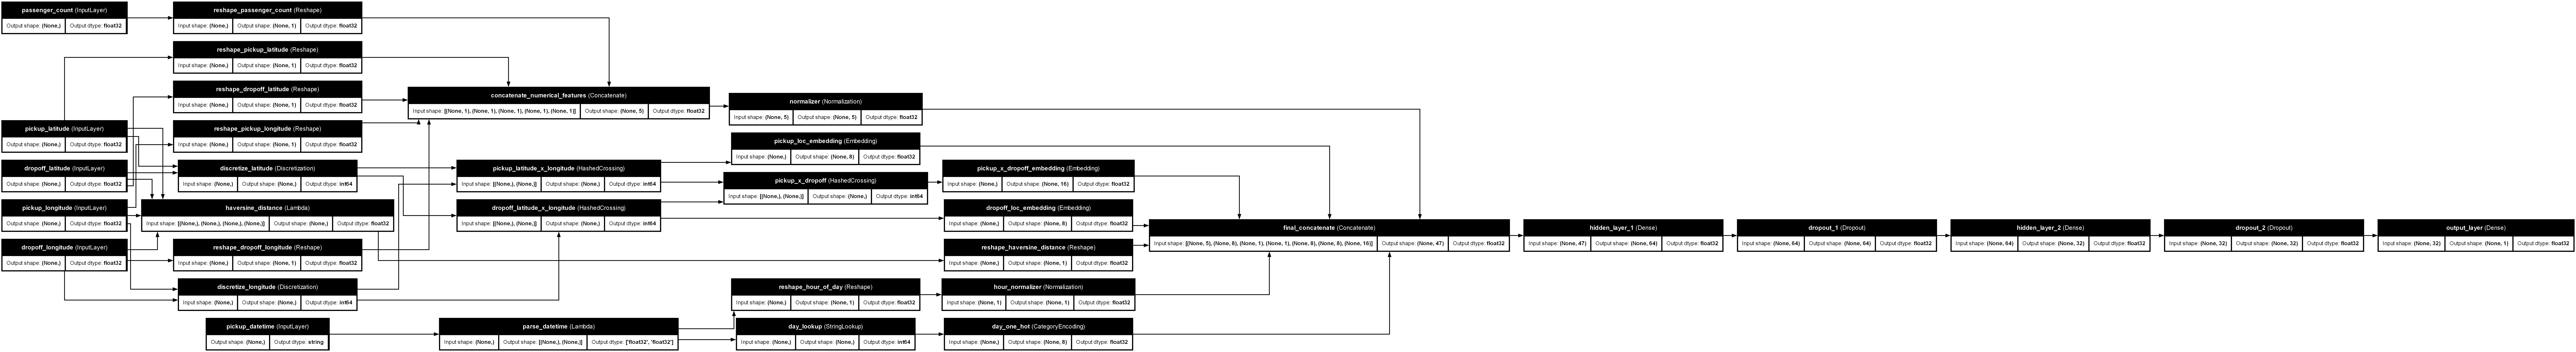

In [9]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_dtype=True, show_shapes=True, rankdir='LR', show_layer_names=True)

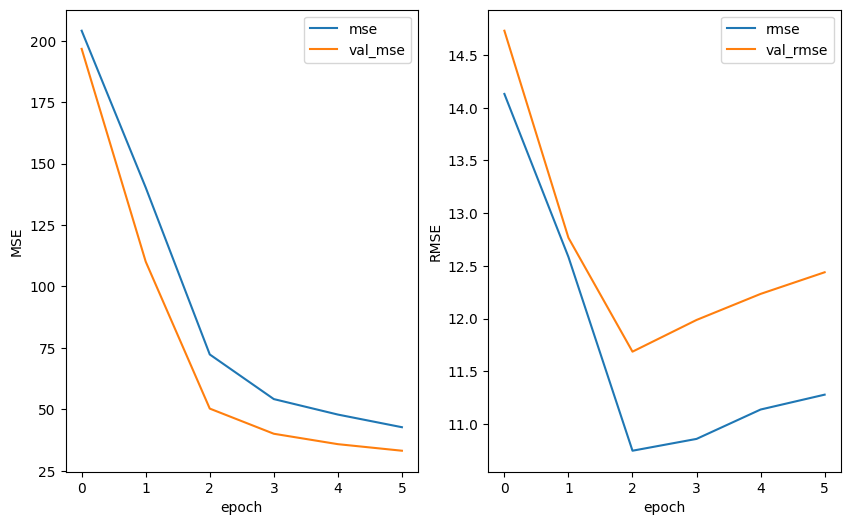

In [10]:
fig = plt.figure(figsize=(10,6))
nr = 1
nc=2

ax = fig.add_subplot(nr,nc,1)
ax.plot(history.history['mse'], label='mse')
ax.plot(history.history['val_mse'], label='val_mse')
ax.set_ylabel('MSE')
ax.set_xlabel('epoch')
ax.legend()
ax = fig.add_subplot(nr,nc,2)
ax.plot(history.history['rmse'], label='rmse')
ax.plot(history.history['val_rmse'], label='val_rmse')
ax.set_ylabel('RMSE')
ax.set_xlabel('epoch')
ax.legend()

In [11]:
def inspect_dataset_dtypes(dataset, dataset_name, num_batches_to_check=500):
    """
    Iterates through a dataset to check the dtype of 'pickup_datetime'.
    Reports the first batch where the dtype is not tf.string.
    """
    print(f"\n--- Starting inspection of '{dataset_name}' dataset ---")
    problem_found = False
    
    # We iterate using .as_numpy_iterator() which is easier for inspection
    for batch_num, (features, label) in enumerate(dataset.take(num_batches_to_check).as_numpy_iterator()):
        
        datetime_tensor = features.get('pickup_datetime')
        
        if datetime_tensor is None:
            print(f"ERROR: Batch {batch_num} is missing the 'pickup_datetime' key!")
            problem_found = True
            break
            
        # The core of the check: what is the dtype of the numpy array?
        # A tf.string tensor becomes an array of bytes (dtype='O' for object).
        # A tf.float32 tensor becomes an array of floats.
        if datetime_tensor.dtype != 'object':
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"  PROBLEM DETECTED in '{dataset_name}' at batch number {batch_num}")
            print(f"  Expected 'pickup_datetime' to be strings, but it is of type: {datetime_tensor.dtype}")
            print(f"  Here are the first 5 problematic values: {datetime_tensor[:5]}")
            print("  This is the source of the 'Cast float to string' error.")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
            problem_found = True
            break
            
        if (batch_num + 1) % 100 == 0:
            print(f"  ... inspected {batch_num + 1} batches of '{dataset_name}', all are tf.string so far.")
            
    if not problem_found:
        print(f"--- SUCCESS: All {num_batches_to_check} inspected batches in '{dataset_name}' have the correct string dtype for 'pickup_datetime'. ---")
    else:
        print(f"--- Inspection of '{dataset_name}' finished. A data type mismatch was found. ---")


# --- Create temporary, non-repeating datasets for inspection ---

# We only need the map that separates features and labels. No shuffle, no repeat.
print("Creating inspection datasets (this may take a moment)...")
inspect_train_ds = tf.data.experimental.make_csv_dataset(train_ds, batch_size=32, column_names=csv_cols, column_defaults=defaults, num_epochs=1, shuffle=False).map(features_and_label)
inspect_eval_ds = tf.data.experimental.make_csv_dataset(validation_ds, batch_size=32, column_names=csv_cols, column_defaults=defaults, num_epochs=1, shuffle=False).map(features_and_label)

# --- Run the inspection ---
inspect_dataset_dtypes(inspect_train_ds, "training (trainds)")
inspect_dataset_dtypes(inspect_eval_ds, "evaluation (evalds)")

Creating inspection datasets (this may take a moment)...

--- Starting inspection of 'training (trainds)' dataset ---
  ... inspected 100 batches of 'training (trainds)', all are tf.string so far.
  ... inspected 200 batches of 'training (trainds)', all are tf.string so far.
--- SUCCESS: All 500 inspected batches in 'training (trainds)' have the correct string dtype for 'pickup_datetime'. ---

--- Starting inspection of 'evaluation (evalds)' dataset ---
--- SUCCESS: All 500 inspected batches in 'evaluation (evalds)' have the correct string dtype for 'pickup_datetime'. ---


Calculating baseline performance on validation set...
Baseline Validation RMSE: 11.6870

Calculating permutation importance...
  Feature: pickup_datetime      | Shuffled RMSE: 11.5700 | Importance (RMSE increase): -0.1171


C:\Users\anantk\AppData\Local\Temp\ipykernel_42384\3033385553.py:24: UserWarning: you are shuffling a 'StringArray' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(shuffled_values)


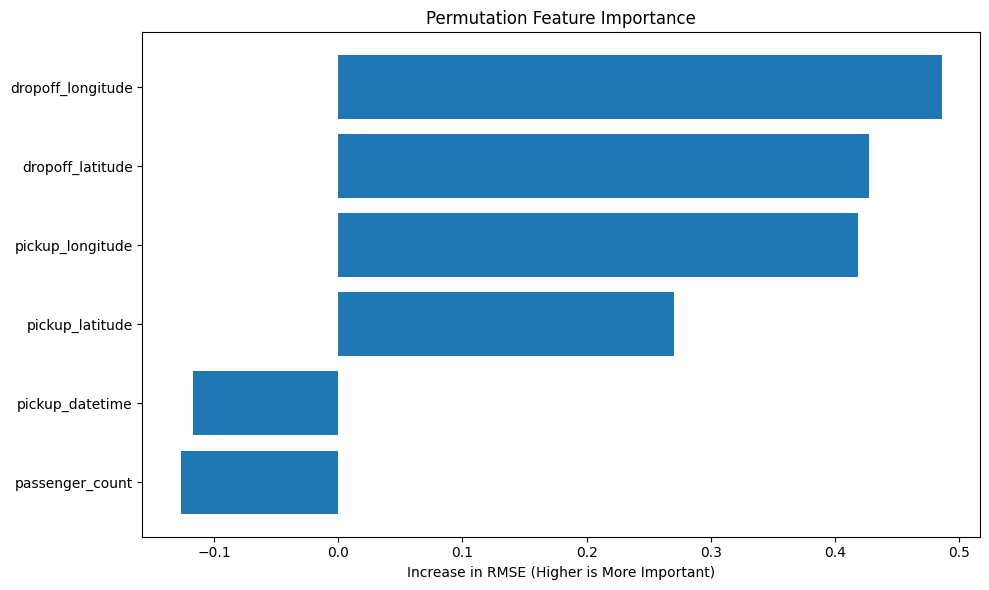

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --- 1. Evaluate baseline performance ---
print("Calculating baseline performance on validation set...")
# Use your ds_to_tf function in 'eval' mode
validation_data_tf = ds_to_tf(validation_ds, batch_size=VALIDATION_BATCH_SIZE, mode='eval')
baseline_loss, _, baseline_rmse = model.evaluate(validation_data_tf, steps=NUM_VALIDATIONS, verbose=0)
print(f"Baseline Validation RMSE: {baseline_rmse:.4f}\n")
# --- 2. Calculate Permutation Importance for each feature ---
# We need the validation data as a pandas DataFrame to easily shuffle columns
df_valid_full = read_data(validation_ds)
labels_valid = df_valid_full.pop('fare_amount')
features_valid = df_valid_full
all_features = num_cols + string_cols
importance_scores = {}
print("Calculating permutation importance...")
for feature in all_features:
# Create a copy to avoid modifying the original validation data
    df_temp = features_valid.copy()
    # Shuffle the values of the current feature
    # .values ensures we shuffle the array, then we put it back
    shuffled_values = df_temp[feature].values
    np.random.shuffle(shuffled_values)
    df_temp[feature] = shuffled_values
    # Convert the modified pandas DataFrame back to a tf.data.Dataset
    # Note: No shuffle or repeat needed for evaluation
    shuffled_ds = tf.data.Dataset.from_tensor_slices((dict(df_temp), labels_valid))
    shuffled_ds = shuffled_ds.batch(VALIDATION_BATCH_SIZE)

    # Evaluate the model on the shuffled data
    shuffled_loss, _, shuffled_rmse = model.evaluate(shuffled_ds, verbose=0)

    # The "importance" is the increase in error
    importance_scores[feature] = shuffled_rmse - baseline_rmse
print(f"  Feature: {feature:<20} | Shuffled RMSE: {shuffled_rmse:.4f} | Importance (RMSE increase): {importance_scores[feature]:.4f}")
# --- 3. Plot the results ---
sorted_features = sorted(importance_scores.items(), key=lambda item: item[1])
feature_names = [item[0] for item in sorted_features]
scores = [item[1] for item in sorted_features]
plt.figure(figsize=(10, 6))
plt.barh(feature_names, scores)
plt.xlabel("Increase in RMSE (Higher is More Important)")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()